In [ ]:
pip install numpy matplotlib seaborn scikit-image tqdm torch    numpy==1.26.4    pillow torchvision

# Using actual data, MAX_SAMPLES = 300

--- Starting Project 2 Analysis ---
[Metal] Found 16472 paired valid samples (e.g., cell0.png).
[Via] Found 116395 paired valid samples (e.g., aes_via1__0_20.png).
Processing up to 600 samples...


  0%|          | 599/132867 [02:36<9:36:02,  3.83it/s] 
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/3977218950.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/3977218950.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")


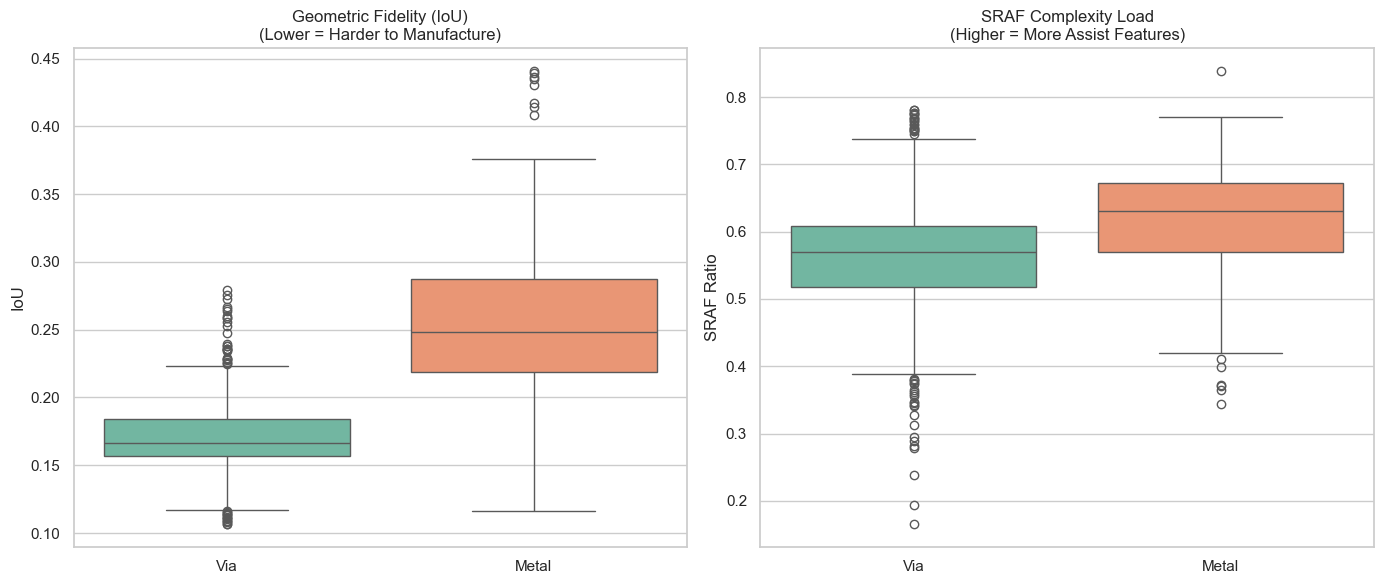

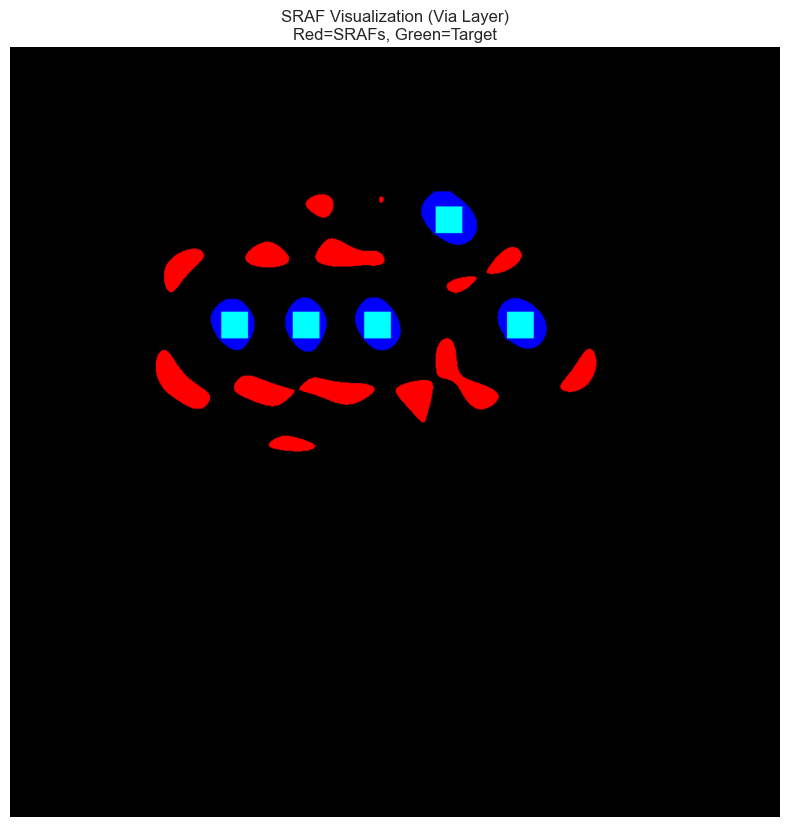

In [ ]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import label, regionprops
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ==========================================
# PART 1: ROBUST DATASET LOADER
# ==========================================

def natural_sort_key(s):
    """
    Sorts strings like 'cell0', 'cell1', 'cell10', 'cell2' 
    in numerical order (0, 1, 2, 10) rather than alphabetical (0, 1, 10, 2).
    """
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

class LithoSeparatedDataset(Dataset):
    """
    Loads paired data from:
    - Target: .../target/cellX.png
    - Mask:   .../pixelILT/cellX.png
    """
    def __init__(self, root_dir, layer_type):
        self.layer_type = layer_type
        self.root_dir = root_dir
        
        self.target_dir = os.path.join(root_dir, 'target')
        self.mask_dir = os.path.join(root_dir, 'pixelILT') # Using PixelILT for masks
        
        # 1. Get all files in Target
        if not os.path.exists(self.target_dir):
            print(f"[{layer_type}] Error: {self.target_dir} does not exist.")
            self.filenames = []
            return

        target_files = set(os.listdir(self.target_dir))
        
        # 2. Get all files in Mask
        if not os.path.exists(self.mask_dir):
            print(f"[{layer_type}] Error: {self.mask_dir} does not exist.")
            self.filenames = []
            return

        mask_files = set(os.listdir(self.mask_dir))
        
        # 3. Find Intersection (Files that exist in BOTH)
        # This prevents crashing if 'cell99.png' is missing from one folder
        common_files = target_files.intersection(mask_files)
        
        # Filter for images and Sort naturally
        valid_exts = {'.png', '.jpg', '.jpeg', '.tif'}
        self.filenames = sorted(
            [f for f in common_files if os.path.splitext(f)[1].lower() in valid_exts],
            key=natural_sort_key
        )
        
        print(f"[{layer_type}] Found {len(self.filenames)} paired valid samples (e.g., {self.filenames[0] if self.filenames else 'None'}).")

        # Transform: Image -> Tensor (0.0 to 1.0)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        # Paths
        target_path = os.path.join(self.target_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        try:
            target_img = Image.open(target_path)
            mask_img = Image.open(mask_path)
            
            # Apply transforms
            target_tensor = self.transform(target_img).squeeze()
            mask_tensor = self.transform(mask_img).squeeze()
            
            return target_tensor, mask_tensor, self.layer_type
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return torch.zeros((512,512)), torch.zeros((512,512)), self.layer_type

# ==========================================
# PART 2: ANALYSIS ENGINE
# ==========================================

class ILTCostAnalyzer:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def binarize(self, tensor):
        if isinstance(tensor, torch.Tensor):
            tensor = tensor.detach().cpu()
        return (tensor > self.threshold).float().numpy()

    def calculate_iou(self, target, mask):
        # Intersection over Union
        intersection = np.logical_and(target, mask).sum()
        union = np.logical_or(target, mask).sum()
        if union == 0: return 1.0
        return intersection / union

    def segment_srafs(self, target_bin, mask_bin):
        # Label connected blobs in mask
        mask_labels = label(mask_bin, connectivity=2) 
        
        sraf_mask = np.zeros_like(mask_bin)
        main_feature_mask = np.zeros_like(mask_bin)
        
        # Iterate over every blob
        for region in regionprops(mask_labels):
            coords = region.coords
            rows, cols = coords[:, 0], coords[:, 1]
            
            # Check overlap with target
            overlap = np.sum(target_bin[rows, cols])
            
            if overlap == 0:
                sraf_mask[rows, cols] = 1 # No overlap = SRAF
            else:
                main_feature_mask[rows, cols] = 1 # Overlap = Main Feature
                
        # Calculate Ratio
        total_mask_pixels = np.sum(mask_bin)
        sraf_pixels = np.sum(sraf_mask)
        
        sraf_ratio = 0.0
        if total_mask_pixels > 0:
            sraf_ratio = sraf_pixels / total_mask_pixels
            
        return sraf_mask, main_feature_mask, sraf_ratio

# ==========================================
# PART 3: EXECUTION
# ==========================================

def run_analysis():
    BASE_PATH = "../lithodata"
    
    # Define Paths
    METAL_PATH = os.path.join(BASE_PATH, "MetalSet")
    VIA_PATH = os.path.join(BASE_PATH, "ViaSet")
    
    # Number of samples to process per set. 
    # Set to None to process all (takes longer).
    MAX_SAMPLES = 300 
    
    print("--- Starting Project 2 Analysis ---")
    
    # 1. Load Data
    metal_ds = LithoSeparatedDataset(METAL_PATH, 'Metal')
    via_ds = LithoSeparatedDataset(VIA_PATH, 'Via')
    
    if len(metal_ds) == 0 and len(via_ds) == 0:
        print("No data found. Check BASE_PATH.")
        return

    # 2. Setup Loop
    full_dataset = torch.utils.data.ConcatDataset([metal_ds, via_ds])
    loader = DataLoader(full_dataset, batch_size=1, shuffle=True) # Shuffle mixes Metal and Via
    
    analyzer = ILTCostAnalyzer()
    
    results = {'Layer Type': [], 'IoU': [], 'SRAF Ratio': []}
    sample_vis_data = None 

    print(f"Processing up to {MAX_SAMPLES*2 if MAX_SAMPLES else 'All'} samples...")

    count = 0
    # Use tqdm for progress bar
    for targets, masks, layer_types in tqdm(loader):
        target = targets[0]
        mask = masks[0]
        l_type = layer_types[0]
        
        # Binarize
        t_bin = analyzer.binarize(target)
        m_bin = analyzer.binarize(mask)
        
        # Skip empty images (sanity check)
        if t_bin.sum() == 0 and m_bin.sum() == 0:
            continue
            
        # Analysis
        iou = analyzer.calculate_iou(t_bin, m_bin)
        sraf_map, main_map, sraf_ratio = analyzer.segment_srafs(t_bin, m_bin)
        
        results['Layer Type'].append(l_type)
        results['IoU'].append(iou)
        results['SRAF Ratio'].append(sraf_ratio)
        
        # Grab a visual sample (Ideally a Via with high SRAF usage)
        if l_type == 'Via' and sraf_ratio > 0.10 and sample_vis_data is None:
            sample_vis_data = (t_bin, m_bin, sraf_map, main_map)
            
        count += 1
        if MAX_SAMPLES and count >= (MAX_SAMPLES * 2):
            break

    # ==========================================
    # PART 4: PLOTTING
    # ==========================================
    
    if not results['Layer Type']:
        print("No results generated.")
        return

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot 1: IoU
    sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
    axes[0].set_title("Geometric Fidelity (IoU)\n(Lower = Harder to Manufacture)")
    axes[0].set_ylabel("IoU")
    
    # Boxplot 2: SRAF Load
    sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")
    axes[1].set_title("SRAF Complexity Load\n(Higher = More Assist Features)")
    axes[1].set_ylabel("SRAF Ratio")
    
    plt.tight_layout()
    plt.show()
    
    # Segmentation Visual
    if sample_vis_data:
        t_bin, m_bin, sraf_map, main_map = sample_vis_data
        
        plt.figure(figsize=(10, 10))
        # RGB Composite
        comp = np.zeros((t_bin.shape[0], t_bin.shape[1], 3))
        comp[:, :, 1] = t_bin      # Green: Target
        comp[:, :, 2] = main_map   # Blue: Printing Mask
        comp[:, :, 0] = sraf_map   # Red: SRAFs
        
        plt.imshow(comp)
        plt.title("SRAF Visualization (Via Layer)\nRed=SRAFs, Green=Target")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    run_analysis()

# Using actual data, MAX_SAMPLES = 1000

--- Starting Project 2 Analysis ---
[Metal] Found 16472 paired valid samples (e.g., cell0.png).
[Via] Found 116395 paired valid samples (e.g., aes_via1__0_20.png).
Processing up to 2000 samples...


  2%|▏         | 1999/132867 [08:26<9:12:52,  3.95it/s] 
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/1752208724.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/1752208724.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")


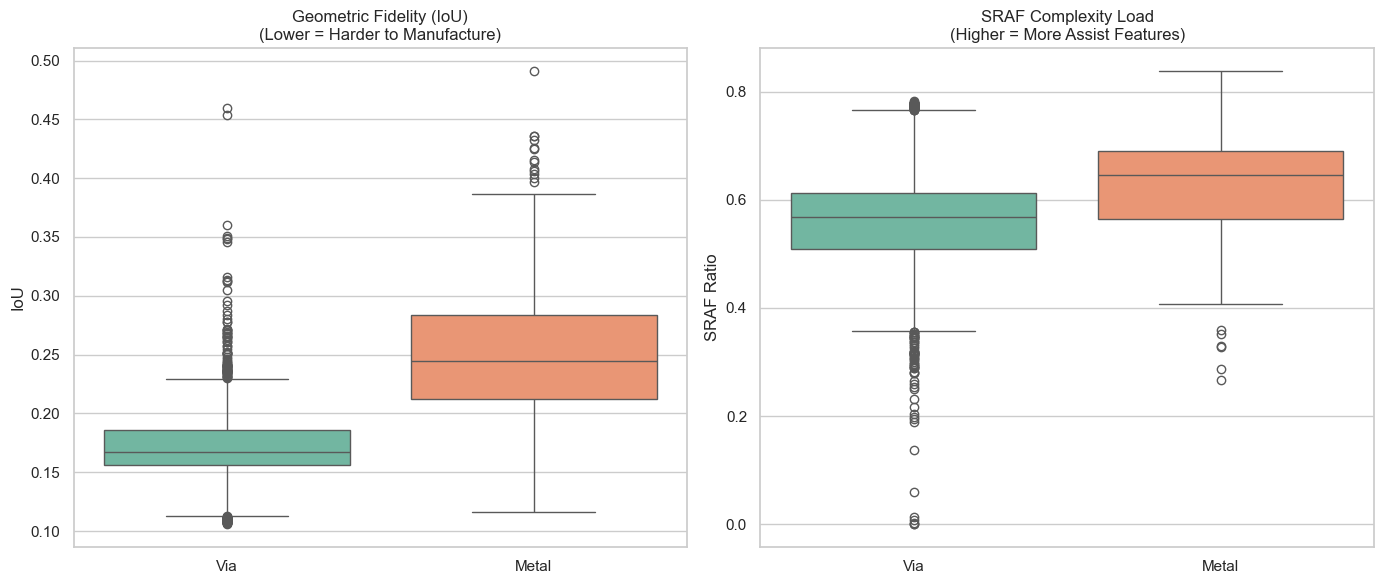

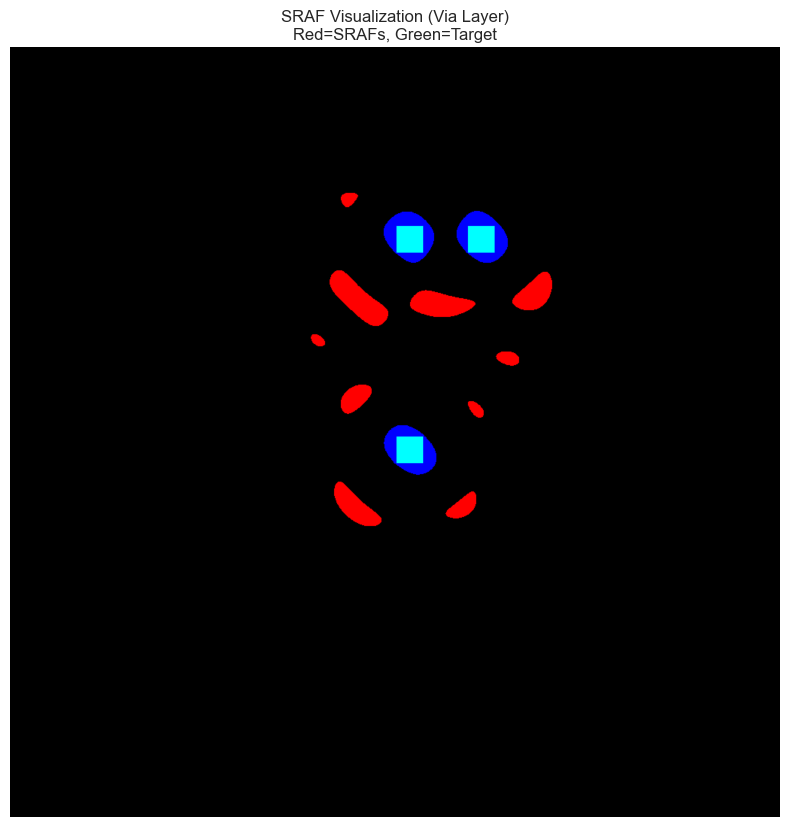

In [ ]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import label, regionprops
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ==========================================
# PART 1: ROBUST DATASET LOADER
# ==========================================

def natural_sort_key(s):
    """
    Sorts strings like 'cell0', 'cell1', 'cell10', 'cell2' 
    in numerical order (0, 1, 2, 10) rather than alphabetical (0, 1, 10, 2).
    """
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

class LithoSeparatedDataset(Dataset):
    """
    Loads paired data from:
    - Target: .../target/cellX.png
    - Mask:   .../pixelILT/cellX.png
    """
    def __init__(self, root_dir, layer_type):
        self.layer_type = layer_type
        self.root_dir = root_dir
        
        self.target_dir = os.path.join(root_dir, 'target')
        self.mask_dir = os.path.join(root_dir, 'pixelILT') # Using PixelILT for masks
        
        # 1. Get all files in Target
        if not os.path.exists(self.target_dir):
            print(f"[{layer_type}] Error: {self.target_dir} does not exist.")
            self.filenames = []
            return

        target_files = set(os.listdir(self.target_dir))
        
        # 2. Get all files in Mask
        if not os.path.exists(self.mask_dir):
            print(f"[{layer_type}] Error: {self.mask_dir} does not exist.")
            self.filenames = []
            return

        mask_files = set(os.listdir(self.mask_dir))
        
        # 3. Find Intersection (Files that exist in BOTH)
        # This prevents crashing if 'cell99.png' is missing from one folder
        common_files = target_files.intersection(mask_files)
        
        # Filter for images and Sort naturally
        valid_exts = {'.png', '.jpg', '.jpeg', '.tif'}
        self.filenames = sorted(
            [f for f in common_files if os.path.splitext(f)[1].lower() in valid_exts],
            key=natural_sort_key
        )
        
        print(f"[{layer_type}] Found {len(self.filenames)} paired valid samples (e.g., {self.filenames[0] if self.filenames else 'None'}).")

        # Transform: Image -> Tensor (0.0 to 1.0)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        # Paths
        target_path = os.path.join(self.target_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        try:
            target_img = Image.open(target_path)
            mask_img = Image.open(mask_path)
            
            # Apply transforms
            target_tensor = self.transform(target_img).squeeze()
            mask_tensor = self.transform(mask_img).squeeze()
            
            return target_tensor, mask_tensor, self.layer_type
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return torch.zeros((512,512)), torch.zeros((512,512)), self.layer_type

# ==========================================
# PART 2: ANALYSIS ENGINE
# ==========================================

class ILTCostAnalyzer:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def binarize(self, tensor):
        if isinstance(tensor, torch.Tensor):
            tensor = tensor.detach().cpu()
        return (tensor > self.threshold).float().numpy()

    def calculate_iou(self, target, mask):
        # Intersection over Union
        intersection = np.logical_and(target, mask).sum()
        union = np.logical_or(target, mask).sum()
        if union == 0: return 1.0
        return intersection / union

    def segment_srafs(self, target_bin, mask_bin):
        # Label connected blobs in mask
        mask_labels = label(mask_bin, connectivity=2) 
        
        sraf_mask = np.zeros_like(mask_bin)
        main_feature_mask = np.zeros_like(mask_bin)
        
        # Iterate over every blob
        for region in regionprops(mask_labels):
            coords = region.coords
            rows, cols = coords[:, 0], coords[:, 1]
            
            # Check overlap with target
            overlap = np.sum(target_bin[rows, cols])
            
            if overlap == 0:
                sraf_mask[rows, cols] = 1 # No overlap = SRAF
            else:
                main_feature_mask[rows, cols] = 1 # Overlap = Main Feature
                
        # Calculate Ratio
        total_mask_pixels = np.sum(mask_bin)
        sraf_pixels = np.sum(sraf_mask)
        
        sraf_ratio = 0.0
        if total_mask_pixels > 0:
            sraf_ratio = sraf_pixels / total_mask_pixels
            
        return sraf_mask, main_feature_mask, sraf_ratio

# ==========================================
# PART 3: EXECUTION
# ==========================================

def run_analysis():
    BASE_PATH = "../lithodata"
    
    # Define Paths
    METAL_PATH = os.path.join(BASE_PATH, "MetalSet")
    VIA_PATH = os.path.join(BASE_PATH, "ViaSet")
    
    # Number of samples to process per set. 
    # Set to None to process all (takes longer).
    MAX_SAMPLES = 1000 
    
    print("--- Starting Project 2 Analysis ---")
    
    # 1. Load Data
    metal_ds = LithoSeparatedDataset(METAL_PATH, 'Metal')
    via_ds = LithoSeparatedDataset(VIA_PATH, 'Via')
    
    if len(metal_ds) == 0 and len(via_ds) == 0:
        print("No data found. Check BASE_PATH.")
        return

    # 2. Setup Loop
    full_dataset = torch.utils.data.ConcatDataset([metal_ds, via_ds])
    loader = DataLoader(full_dataset, batch_size=1, shuffle=True) # Shuffle mixes Metal and Via
    
    analyzer = ILTCostAnalyzer()
    
    results = {'Layer Type': [], 'IoU': [], 'SRAF Ratio': []}
    sample_vis_data = None 

    print(f"Processing up to {MAX_SAMPLES*2 if MAX_SAMPLES else 'All'} samples...")

    count = 0
    # Use tqdm for progress bar
    for targets, masks, layer_types in tqdm(loader):
        target = targets[0]
        mask = masks[0]
        l_type = layer_types[0]
        
        # Binarize
        t_bin = analyzer.binarize(target)
        m_bin = analyzer.binarize(mask)
        
        # Skip empty images (sanity check)
        if t_bin.sum() == 0 and m_bin.sum() == 0:
            continue
            
        # Analysis
        iou = analyzer.calculate_iou(t_bin, m_bin)
        sraf_map, main_map, sraf_ratio = analyzer.segment_srafs(t_bin, m_bin)
        
        results['Layer Type'].append(l_type)
        results['IoU'].append(iou)
        results['SRAF Ratio'].append(sraf_ratio)
        
        # Grab a visual sample (Ideally a Via with high SRAF usage)
        if l_type == 'Via' and sraf_ratio > 0.10 and sample_vis_data is None:
            sample_vis_data = (t_bin, m_bin, sraf_map, main_map)
            
        count += 1
        if MAX_SAMPLES and count >= (MAX_SAMPLES * 2):
            break

    # ==========================================
    # PART 4: PLOTTING
    # ==========================================
    
    if not results['Layer Type']:
        print("No results generated.")
        return

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot 1: IoU
    sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
    axes[0].set_title("Geometric Fidelity (IoU)\n(Lower = Harder to Manufacture)")
    axes[0].set_ylabel("IoU")
    
    # Boxplot 2: SRAF Load
    sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")
    axes[1].set_title("SRAF Complexity Load\n(Higher = More Assist Features)")
    axes[1].set_ylabel("SRAF Ratio")
    
    plt.tight_layout()
    plt.show()
    
    # Segmentation Visual
    if sample_vis_data:
        t_bin, m_bin, sraf_map, main_map = sample_vis_data
        
        plt.figure(figsize=(10, 10))
        # RGB Composite
        comp = np.zeros((t_bin.shape[0], t_bin.shape[1], 3))
        comp[:, :, 1] = t_bin      # Green: Target
        comp[:, :, 2] = main_map   # Blue: Printing Mask
        comp[:, :, 0] = sraf_map   # Red: SRAFs
        
        plt.imshow(comp)
        plt.title("SRAF Visualization (Via Layer)\nRed=SRAFs, Green=Target")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    run_analysis()

# Using actual data, MAX_SAMPLES = 5000

--- Starting Project 2 Analysis ---
[Metal] Found 16472 paired valid samples (e.g., cell0.png).
[Via] Found 116395 paired valid samples (e.g., aes_via1__0_20.png).
Processing up to 10000 samples...


  8%|▊         | 9999/132867 [44:42<9:09:25,  3.73it/s]   
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/1493730841.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_3372/1493730841.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")


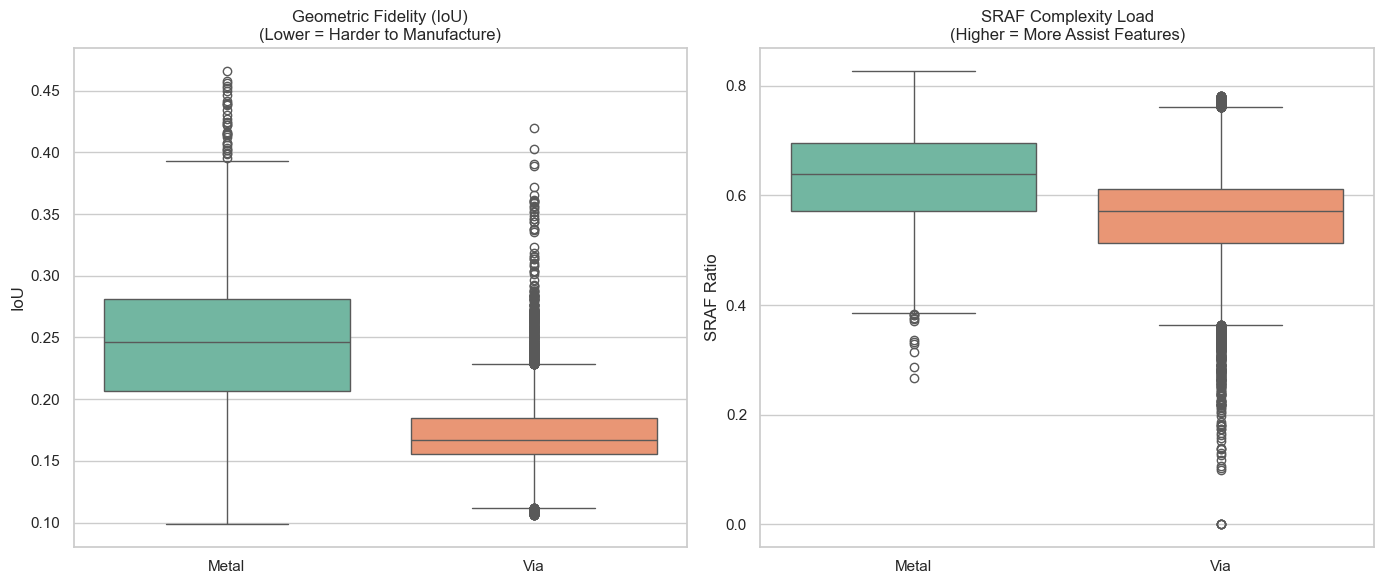

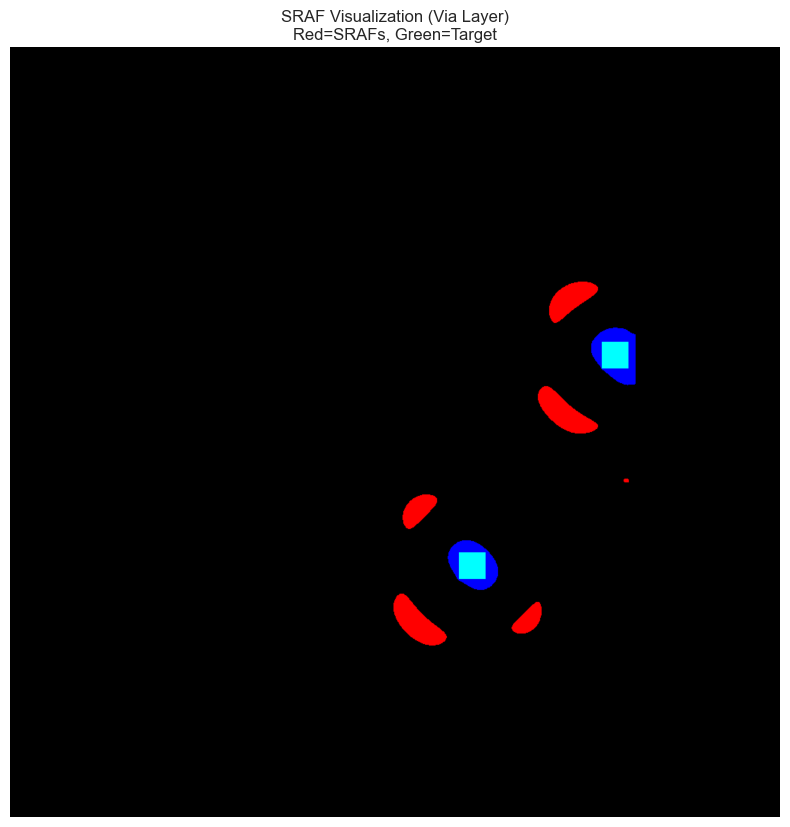

In [ ]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import label, regionprops
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ==========================================
# PART 1: ROBUST DATASET LOADER
# ==========================================

def natural_sort_key(s):
    """
    Sorts strings like 'cell0', 'cell1', 'cell10', 'cell2' 
    in numerical order (0, 1, 2, 10) rather than alphabetical (0, 1, 10, 2).
    """
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

class LithoSeparatedDataset(Dataset):
    """
    Loads paired data from:
    - Target: .../target/cellX.png
    - Mask:   .../pixelILT/cellX.png
    """
    def __init__(self, root_dir, layer_type):
        self.layer_type = layer_type
        self.root_dir = root_dir
        
        self.target_dir = os.path.join(root_dir, 'target')
        self.mask_dir = os.path.join(root_dir, 'pixelILT') # Using PixelILT for masks
        
        # 1. Get all files in Target
        if not os.path.exists(self.target_dir):
            print(f"[{layer_type}] Error: {self.target_dir} does not exist.")
            self.filenames = []
            return

        target_files = set(os.listdir(self.target_dir))
        
        # 2. Get all files in Mask
        if not os.path.exists(self.mask_dir):
            print(f"[{layer_type}] Error: {self.mask_dir} does not exist.")
            self.filenames = []
            return

        mask_files = set(os.listdir(self.mask_dir))
        
        # 3. Find Intersection (Files that exist in BOTH)
        # This prevents crashing if 'cell99.png' is missing from one folder
        common_files = target_files.intersection(mask_files)
        
        # Filter for images and Sort naturally
        valid_exts = {'.png', '.jpg', '.jpeg', '.tif'}
        self.filenames = sorted(
            [f for f in common_files if os.path.splitext(f)[1].lower() in valid_exts],
            key=natural_sort_key
        )
        
        print(f"[{layer_type}] Found {len(self.filenames)} paired valid samples (e.g., {self.filenames[0] if self.filenames else 'None'}).")

        # Transform: Image -> Tensor (0.0 to 1.0)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        # Paths
        target_path = os.path.join(self.target_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        try:
            target_img = Image.open(target_path)
            mask_img = Image.open(mask_path)
            
            # Apply transforms
            target_tensor = self.transform(target_img).squeeze()
            mask_tensor = self.transform(mask_img).squeeze()
            
            return target_tensor, mask_tensor, self.layer_type
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return torch.zeros((512,512)), torch.zeros((512,512)), self.layer_type

# ==========================================
# PART 2: ANALYSIS ENGINE
# ==========================================

class ILTCostAnalyzer:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def binarize(self, tensor):
        if isinstance(tensor, torch.Tensor):
            tensor = tensor.detach().cpu()
        return (tensor > self.threshold).float().numpy()

    def calculate_iou(self, target, mask):
        # Intersection over Union
        intersection = np.logical_and(target, mask).sum()
        union = np.logical_or(target, mask).sum()
        if union == 0: return 1.0
        return intersection / union

    def segment_srafs(self, target_bin, mask_bin):
        # Label connected blobs in mask
        mask_labels = label(mask_bin, connectivity=2) 
        
        sraf_mask = np.zeros_like(mask_bin)
        main_feature_mask = np.zeros_like(mask_bin)
        
        # Iterate over every blob
        for region in regionprops(mask_labels):
            coords = region.coords
            rows, cols = coords[:, 0], coords[:, 1]
            
            # Check overlap with target
            overlap = np.sum(target_bin[rows, cols])
            
            if overlap == 0:
                sraf_mask[rows, cols] = 1 # No overlap = SRAF
            else:
                main_feature_mask[rows, cols] = 1 # Overlap = Main Feature
                
        # Calculate Ratio
        total_mask_pixels = np.sum(mask_bin)
        sraf_pixels = np.sum(sraf_mask)
        
        sraf_ratio = 0.0
        if total_mask_pixels > 0:
            sraf_ratio = sraf_pixels / total_mask_pixels
            
        return sraf_mask, main_feature_mask, sraf_ratio

# ==========================================
# PART 3: EXECUTION
# ==========================================

def run_analysis():
    BASE_PATH = "../lithodata"
    
    # Define Paths
    METAL_PATH = os.path.join(BASE_PATH, "MetalSet")
    VIA_PATH = os.path.join(BASE_PATH, "ViaSet")
    
    # Number of samples to process per set. 
    # Set to None to process all (takes longer).
    MAX_SAMPLES = 5000 
    
    print("--- Starting Project 2 Analysis ---")
    
    # 1. Load Data
    metal_ds = LithoSeparatedDataset(METAL_PATH, 'Metal')
    via_ds = LithoSeparatedDataset(VIA_PATH, 'Via')
    
    if len(metal_ds) == 0 and len(via_ds) == 0:
        print("No data found. Check BASE_PATH.")
        return

    # 2. Setup Loop
    full_dataset = torch.utils.data.ConcatDataset([metal_ds, via_ds])
    loader = DataLoader(full_dataset, batch_size=1, shuffle=True) # Shuffle mixes Metal and Via
    
    analyzer = ILTCostAnalyzer()
    
    results = {'Layer Type': [], 'IoU': [], 'SRAF Ratio': []}
    sample_vis_data = None 

    print(f"Processing up to {MAX_SAMPLES*2 if MAX_SAMPLES else 'All'} samples...")

    count = 0
    # Use tqdm for progress bar
    for targets, masks, layer_types in tqdm(loader):
        target = targets[0]
        mask = masks[0]
        l_type = layer_types[0]
        
        # Binarize
        t_bin = analyzer.binarize(target)
        m_bin = analyzer.binarize(mask)
        
        # Skip empty images (sanity check)
        if t_bin.sum() == 0 and m_bin.sum() == 0:
            continue
            
        # Analysis
        iou = analyzer.calculate_iou(t_bin, m_bin)
        sraf_map, main_map, sraf_ratio = analyzer.segment_srafs(t_bin, m_bin)
        
        results['Layer Type'].append(l_type)
        results['IoU'].append(iou)
        results['SRAF Ratio'].append(sraf_ratio)
        
        # Grab a visual sample (Ideally a Via with high SRAF usage)
        if l_type == 'Via' and sraf_ratio > 0.10 and sample_vis_data is None:
            sample_vis_data = (t_bin, m_bin, sraf_map, main_map)
            
        count += 1
        if MAX_SAMPLES and count >= (MAX_SAMPLES * 2):
            break

    # ==========================================
    # PART 4: PLOTTING
    # ==========================================
    
    if not results['Layer Type']:
        print("No results generated.")
        return

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot 1: IoU
    sns.boxplot(x=results['Layer Type'], y=results['IoU'], ax=axes[0], palette="Set2")
    axes[0].set_title("Geometric Fidelity (IoU)\n(Lower = Harder to Manufacture)")
    axes[0].set_ylabel("IoU")
    
    # Boxplot 2: SRAF Load
    sns.boxplot(x=results['Layer Type'], y=results['SRAF Ratio'], ax=axes[1], palette="Set2")
    axes[1].set_title("SRAF Complexity Load\n(Higher = More Assist Features)")
    axes[1].set_ylabel("SRAF Ratio")
    
    plt.tight_layout()
    plt.show()
    
    # Segmentation Visual
    if sample_vis_data:
        t_bin, m_bin, sraf_map, main_map = sample_vis_data
        
        plt.figure(figsize=(10, 10))
        # RGB Composite
        comp = np.zeros((t_bin.shape[0], t_bin.shape[1], 3))
        comp[:, :, 1] = t_bin      # Green: Target
        comp[:, :, 2] = main_map   # Blue: Printing Mask
        comp[:, :, 0] = sraf_map   # Red: SRAFs
        
        plt.imshow(comp)
        plt.title("SRAF Visualization (Via Layer)\nRed=SRAFs, Green=Target")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    run_analysis()